# Практика

In [ ]:
!pip install psycopg2

In [ ]:
import psycopg2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


# доступны student-ы от 0 до 30
# в этот раз важно взять своего student-а. Если в коде ниже увидите, что в вашей базе уже есть таблицы, то выберите другого пользователя.
# НЕ ЗАБУДЬТЕ ВЫПОЛНИТЬ КОД ЭТОЙ КЛЕТКИ



DB_HOST = '89.223.95.138'
DB_USER = 'student_23'
DB_USER_PASSWORD = 'student_23'
DB_NAME = 'student_23'

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
conn = psycopg2.connect(host=DB_HOST, user=DB_USER, password=DB_USER_PASSWORD, dbname=DB_NAME)
pd.read_sql_query("""
SELECT *
FROM pg_catalog.pg_tables
WHERE schemaname != 'pg_catalog' AND 
    schemaname != 'information_schema'
    """, conn)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity


### Шаг 1
Сгенерируем данные по показам, кликам, и деньгам по 5 объявлениям с названиями Advertising_0, Advertising_1, ...

Просто выполните две клетки ниже

In [ ]:
adv_sample = 'Advertising_{}'
advertisings = []
for i in range(5):
  advertisings.append(adv_sample.format(i))
advertisings

['Advertising_0',
 'Advertising_1',
 'Advertising_2',
 'Advertising_3',
 'Advertising_4']

In [ ]:
from datetime import datetime, timedelta, date
DATE_FORMAT = '%Y-%m-%d'
start_date = date(2019, 8, 1)
data = {}
for adv_id in range(1, len(advertisings)+1):
  day_data = []
  data[adv_id] = []
  for idx, events_number in enumerate(np.random.random_integers(50, 100, 30)):
    events = np.zeros(events_number)
    events[np.random.rand(events_number) > 0.5] = 1
    money = np.round(events * np.random.rand(events_number)*10 + np.random.rand(events_number), 2)
    dt = start_date + timedelta(days=idx)
    dates = [dt.strftime(DATE_FORMAT) for j in range(events_number)]
    day_data = list(zip(dates, events, money))
    data[adv_id] += day_data
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(50, 100 + 1) instead
  


{1: [('2019-08-01', 1.0, 6.39),
  ('2019-08-01', 0.0, 0.81),
  ('2019-08-01', 0.0, 0.58),
  ('2019-08-01', 1.0, 9.61),
  ('2019-08-01', 1.0, 7.56),
  ('2019-08-01', 0.0, 0.71),
  ('2019-08-01', 1.0, 0.37),
  ('2019-08-01', 0.0, 0.4),
  ('2019-08-01', 0.0, 0.93),
  ('2019-08-01', 0.0, 0.5),
  ('2019-08-01', 0.0, 0.65),
  ('2019-08-01', 0.0, 0.24),
  ('2019-08-01', 0.0, 0.29),
  ('2019-08-01', 0.0, 0.05),
  ('2019-08-01', 0.0, 0.37),
  ('2019-08-01', 0.0, 0.22),
  ('2019-08-01', 1.0, 7.15),
  ('2019-08-01', 1.0, 9.19),
  ('2019-08-01', 0.0, 0.05),
  ('2019-08-01', 0.0, 0.88),
  ('2019-08-01', 1.0, 8.11),
  ('2019-08-01', 0.0, 0.33),
  ('2019-08-01', 0.0, 0.5),
  ('2019-08-01', 1.0, 5.31),
  ('2019-08-01', 0.0, 0.91),
  ('2019-08-01', 0.0, 0.86),
  ('2019-08-01', 1.0, 10.26),
  ('2019-08-01', 0.0, 0.87),
  ('2019-08-01', 1.0, 8.76),
  ('2019-08-01', 1.0, 9.36),
  ('2019-08-01', 1.0, 9.51),
  ('2019-08-01', 1.0, 5.09),
  ('2019-08-01', 1.0, 8.03),
  ('2019-08-01', 0.0, 0.89),
  ('2019-08-0

In [ ]:
data.keys()

dict_keys([1, 2, 3, 4, 5])

Теперь в массиве advertisings у нас лежат названия объявлений, а в словаре data ключом является идентификатор объявления в нашей будущей базе данных (при использовании SERIAL PRIMARY KEY идентификаторы будут от 1 до 5 соответственно). 

Значениями в словаре data являются массивы tuple-ов в которых по порядку записана дата события, тип события, а также кол-во денег, которое стоило это событие. 

*   0 это показ
*   1 это клик (если был клик, то был и показ)
*   кол-во денег указано в рублях



In [ ]:
data[1][0][2]

6.39

### Шаг 2
Создадим структуру таблиц.
Нам понадобится создать две таблицы. В одной будут храниться названия объявлений с их уникальным идентификатором, а во второй будут храниться события, относящиеся к этим объявлениям. При этом вторая таблица связана с первой таблицей первичным ключом.

In [ ]:
# выполните, чтобы получить объект соединения
#conn = psycopg2.connect(DB_HOST, DB_USER, DB_USER_PASSWORD, DB_NAME) # создаём соединение
conn = psycopg2.connect(host=DB_HOST, user=DB_USER, password=DB_USER_PASSWORD, dbname=DB_NAME)


In [ ]:
# выполните эту клетку если захотите удалить ошибочно созданную таблицу adv_glossary
query = "DROP TABLE IF EXISTS adv_glossary"

conn.cursor().execute(query) # выполняем запрос
conn.commit() # сохраняем изменения

In [ ]:
# выполните эту клетку если захотите удалить ошибочно созданную таблицу adv_events
query = "DROP TABLE IF EXISTS adv_events"


conn.cursor().execute(query) # выполняем запрос
conn.commit() # сохраняем изменения

In [ ]:
query = """CREATE TABLE adv_events(adv_id serial PRIMARY KEY,
                                              name varchar(50));"""
conn.cursor().execute(query) # выполняем запрос
conn.commit() # сохраняем изменения                                             

In [ ]:
query = """CREATE TABLE adv_glossary(data_id serial PRIMARY KEY,
                                              date_action date,
                                              action smallint,
                                              cost money,
                                              adv_id smallint);"""
conn.cursor().execute(query) # выполняем запрос
conn.commit() # сохраняем изменения   

In [ ]:
query = """
ALTER TABLE adv_glossary ADD
    FOREIGN KEY (adv_id) REFERENCES adv_events(adv_id)"""

conn.cursor().execute(query) # выполняем запрос
conn.commit() # сохраняем изменения   

In [ ]:
# напишите запрос для создания таблицы с объявлениями

In [ ]:
# напишите запрос для создания таблицы с событиями по объявлениям

In [ ]:
# а также добавьте ограничение целостности на идентификатор объявления

### Шаг 3
Теперь, когда таблицы созданы, наполните их данными. Это может занять некоторое время, подождите, выпейте чаю;). Заметьте, если внешний ключ создан правильно, то база не даст вписать данные с несуществующими связями. 
С какой базы надо начать наполнение?

In [ ]:
for ind, ev in enumerate(advertisings):
  query = "insert into adv_events(name) values('{}')".format(ev)
  conn.cursor().execute(query) # выполняем запрос
  conn.commit() # сохраняем изменения   

In [ ]:
for i in data.keys():
  for j in data[i]:
    query = "insert into adv_glossary(date_action, action, cost, adv_id) values('{}',{},{},{})".format(j[0], j[1], j[2], i)
    conn.cursor().execute(query) # выполняем запрос
    conn.commit() # сохраняем изменения 

### Шаг 4
Проверьте, что данные действительно появились в таблицах

In [75]:
pd.read_sql_query("""
select * from adv_glossary
""", conn)

,data_id,date_action,action,cost,adv_id
0,1,2019-08-01,1,$6.39,1
1,2,2019-08-01,0,$0.81,1
2,3,2019-08-01,0,$0.58,1
3,4,2019-08-01,1,$9.61,1
4,5,2019-08-01,1,$7.56,1
...,...,...,...,...,...
11329,11330,2019-08-30,0,$0.59,5
11330,11331,2019-08-30,1,$0.51,5
11331,11332,2019-08-30,0,$0.45,5
11332,11333,2019-08-30,1,$4.17,5


In [76]:
pd.read_sql_query("""
select * from adv_events
""", conn)

,adv_id,name
0,1,Advertising_0
1,2,Advertising_1
2,3,Advertising_2
3,4,Advertising_3
4,5,Advertising_4


### Шаг 5
Теперь для каждого объявления посчитайте [CTR](https://ru.wikipedia.org/wiki/CTR_(%D0%98%D0%BD%D1%82%D0%B5%D1%80%D0%BD%D0%B5%D1%82)#targetText=CTR%20(%D1%81%D0%B8%D0%BD%D0%BE%D0%BD%D0%B8%D0%BC%20%E2%80%94%20%D0%BA%D0%BB%D0%B8%D0%BA%D0%B0%D0%B1%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C%2C%20%D0%BE%D1%82,%D1%87%D0%B8%D1%81%D0%BB%D1%83%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%BE%D0%B2%2C%20%D0%B8%D0%B7%D0%BC%D0%B5%D1%80%D1%8F%D0%B5%D1%82%D1%81%D1%8F%20%D0%B2%20%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D0%BD%D1%82%D0%B0%D1%85.&targetText=%D0%9D%D0%B0%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%3A%20%D1%80%D0%B5%D0%BA%D0%BB%D0%B0%D0%BC%D0%BD%D1%8B%D0%B9%20%D0%B1%D0%BB%D0%BE%D0%BA%20%D0%B1%D1%8B%D0%BB%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD,%D0%BD%D0%B0%20%D0%BD%D0%B5%D0%B3%D0%BE%20%D0%BA%D0%BB%D0%B8%D0%BA%D0%BD%D1%83%D0%BB%D0%B8%202%20%D1%80%D0%B0%D0%B7%D0%B0.) и [CPM](http://promo-sa.ru/seo-terms/cpm) за каждый день с помощью sql запроса, и выведите результат в pandas.

В результирующем датафрейме должно быть отражено название объявления, дата, CTR за день, CPM за день.

In [149]:
# data = pd.read_sql_query("", conn) # считаем данные в переменную
# Всё сводится к тому ,чтобы посчитать кол-во кликов и кол-во показов. 
df_with_m = pd.read_sql_query("""
SELECT name,
       date_action,
       round(avg(action)*100, 2)AS CTR,
       (sum(cost)*1000/count(cost))AS CPM
FROM adv_glossary AS g
JOIN adv_events AS e ON e.adv_id = g.adv_id
GROUP BY (name,
          date_action)
ORDER BY(name,
         date_action)
""", conn)
df_with_m

,name,date_action,ctr,cpm
0,Advertising_0,2019-08-01,41.54,"$2,933.23"
1,Advertising_0,2019-08-02,48.96,"$3,189.37"
2,Advertising_0,2019-08-03,48.21,"$3,293.21"
3,Advertising_0,2019-08-04,44.71,"$2,798.70"
4,Advertising_0,2019-08-05,53.16,"$3,051.89"
...,...,...,...,...
145,Advertising_4,2019-08-26,48.39,"$3,006.77"
146,Advertising_4,2019-08-27,53.42,"$3,224.10"
147,Advertising_4,2019-08-28,42.17,"$2,689.27"
148,Advertising_4,2019-08-29,43.21,"$2,776.79"


### Шаг 6
Но на таблицу не так интересно смотреть как на графики...

Для каждого объявления постройте дневные графики CTR и CPM.

На всякий случай проследите, чтобы данные были нарисованы по возрастанию даты. Для этого надо либо отсортировать датафрейм по дате, либо проследить, что тип данных у это поля в pandas что-то типа date. Чтобы посмотреть типы полей в pandas используйте атрибут датафрейма .dtypes

In [150]:
df_with_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         150 non-null    object 
 1   date_action  150 non-null    object 
 2   ctr          150 non-null    float64
 3   cpm          150 non-null    object 
dtypes: float64(1), object(3)
memory usage: 4.8+ KB


In [151]:
df_with_m = df_with_m.astype({'date_action': 'datetime64[D]'})
df_with_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   name         150 non-null    object        
 1   date_action  150 non-null    datetime64[ns]
 2   ctr          150 non-null    float64       
 3   cpm          150 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 4.8+ KB


In [152]:
df_with_m['cpm'] = df_with_m['cpm'].str.replace(',', '').str[1:]
df_with_m

,name,date_action,ctr,cpm
0,Advertising_0,2019-08-01,41.54,2933.23
1,Advertising_0,2019-08-02,48.96,3189.37
2,Advertising_0,2019-08-03,48.21,3293.21
3,Advertising_0,2019-08-04,44.71,2798.70
4,Advertising_0,2019-08-05,53.16,3051.89
...,...,...,...,...
145,Advertising_4,2019-08-26,48.39,3006.77
146,Advertising_4,2019-08-27,53.42,3224.10
147,Advertising_4,2019-08-28,42.17,2689.27
148,Advertising_4,2019-08-29,43.21,2776.79


In [189]:
df_with_m = df_with_m.astype({'cpm': 'float64'})
df_with_m = df_with_m.set_index('date_action')
df_with_m

,name,ctr,cpm
date_action,,,
2019-08-01,Advertising_0,41.54,2933.23
2019-08-02,Advertising_0,48.96,3189.37
2019-08-03,Advertising_0,48.21,3293.21
2019-08-04,Advertising_0,44.71,2798.70
2019-08-05,Advertising_0,53.16,3051.89
...,...,...,...
2019-08-26,Advertising_4,48.39,3006.77
2019-08-27,Advertising_4,53.42,3224.10
2019-08-28,Advertising_4,42.17,2689.27


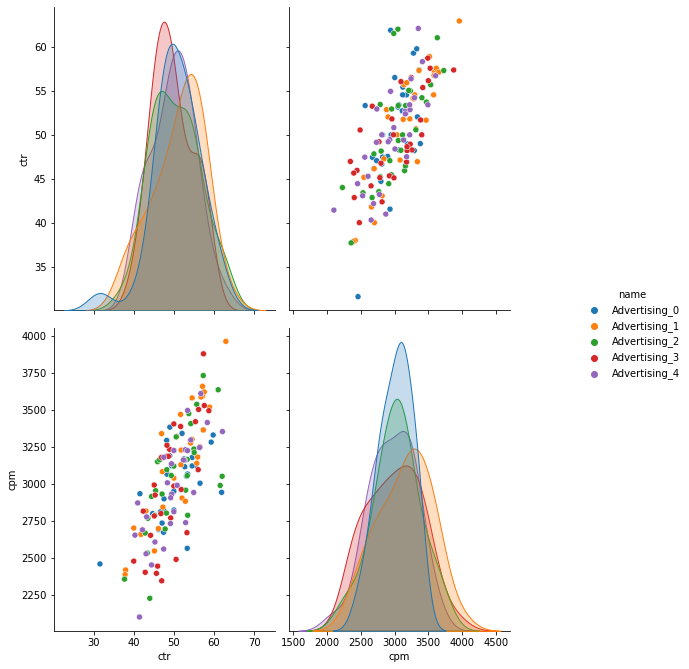

In [190]:
g = sns.pairplot(df_with_m, hue ='name')
g.fig.set_size_inches(10, 10)

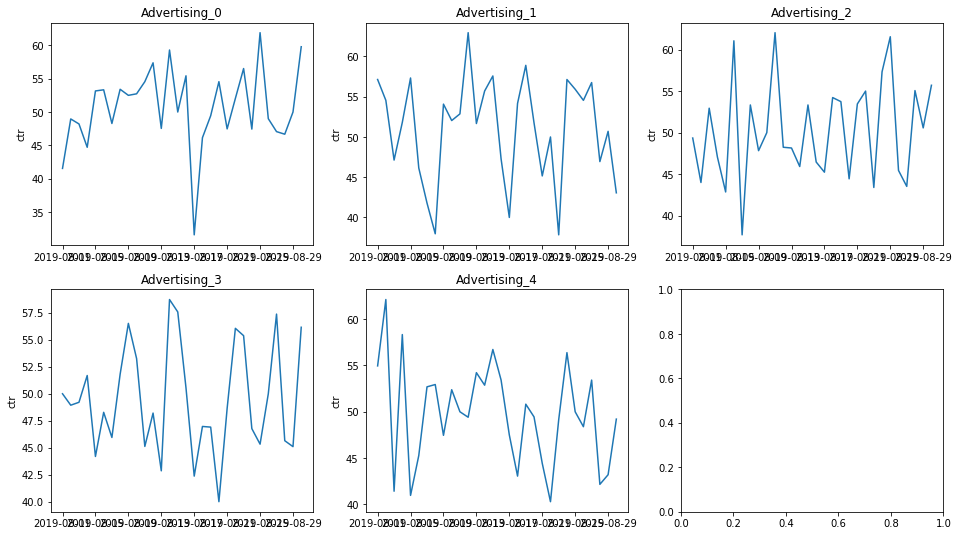

In [304]:
fig, ax = plt.subplots(2, 3, figsize=(16,9))
for ind, i in enumerate(ax.ravel()[:-1]):
  ctr = df_with_m[df_with_m['name'] == advertisings[ind]]['ctr']
  i.plot(ctr)
  i.set_title('{}'.format(advertisings[ind]))
  i.set_ylabel('ctr')

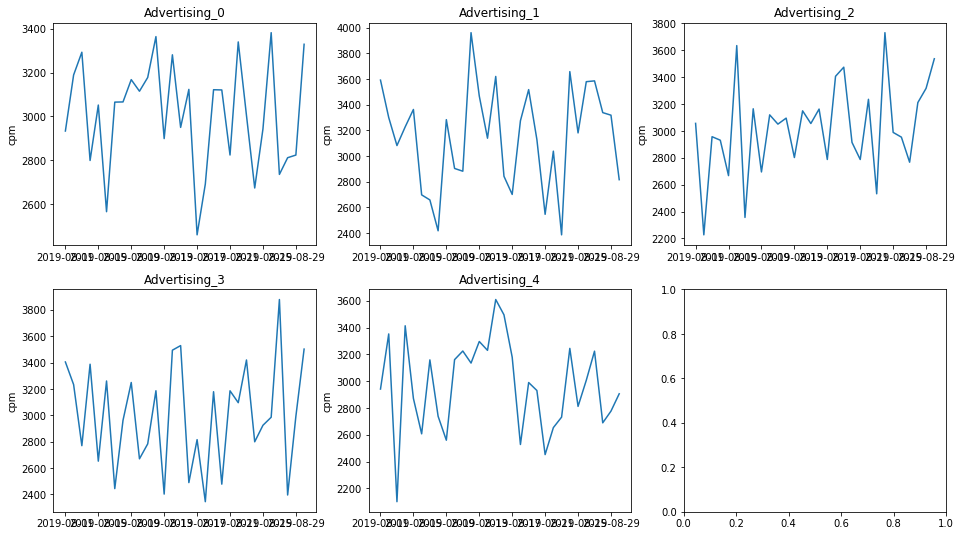

In [303]:
fig, ax = plt.subplots(2, 3, figsize=(16,9))
for ind, i in enumerate(ax.ravel()[:-1]):
  ctr = df_with_m[df_with_m['name'] == advertisings[ind]]['cpm']
  i.plot(ctr)
  i.set_title('{}'.format(advertisings[ind]))
  i.set_ylabel('cpm')

In [310]:
df_cpm = df_with_m.pivot(columns='name')['cpm']
df_ctr = df_with_m.pivot(columns='name')['ctr']

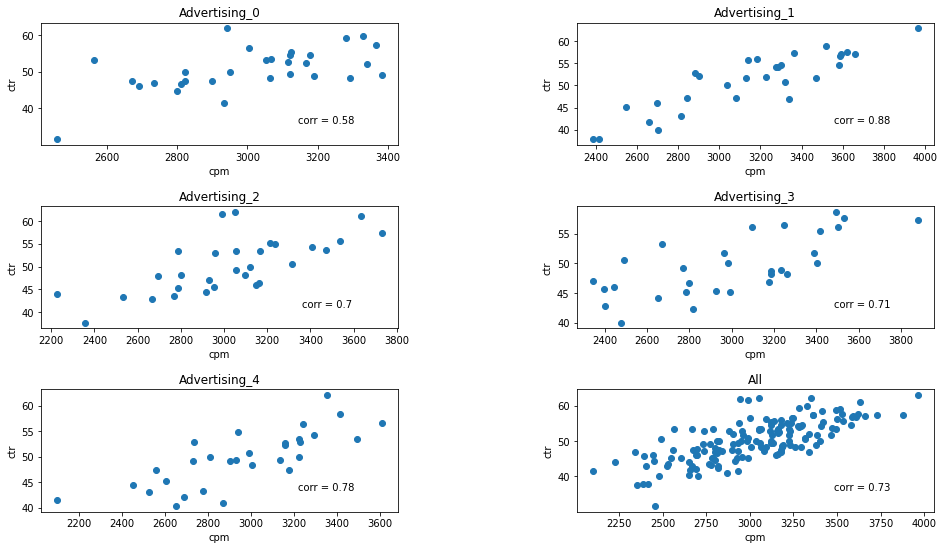

In [297]:
fig, axes = plt.subplots(3, 2, figsize=(16,9))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for ind, ax in enumerate(axes.ravel()):
  if(ind < 5):
    x = cpm.iloc[:,ind]
    y = ctr.iloc[:,ind]
    ax.scatter(x, y)
    ax.set_ylabel('ctr')
    ax.set_xlabel('cpm')
    ax.text(0.8, 0.2,'corr = {}'.format(round(x.corr(y), 2)),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)
    ax.set_title('{}'.format(cpm.columns[ind]))
  else:
    x = df_with_m['cpm']
    y = df_with_m['ctr']
    ax.scatter(x, y)
    ax.text(0.8, 0.2,'corr = {}'.format(round(x.corr(y), 2)),
      horizontalalignment='center',
      verticalalignment='center',
      transform = ax.transAxes)
    ax.set_title('All')
    ax.set_ylabel('ctr')
    ax.set_xlabel('cpm')

Text(0, 0.5, 'cpm')

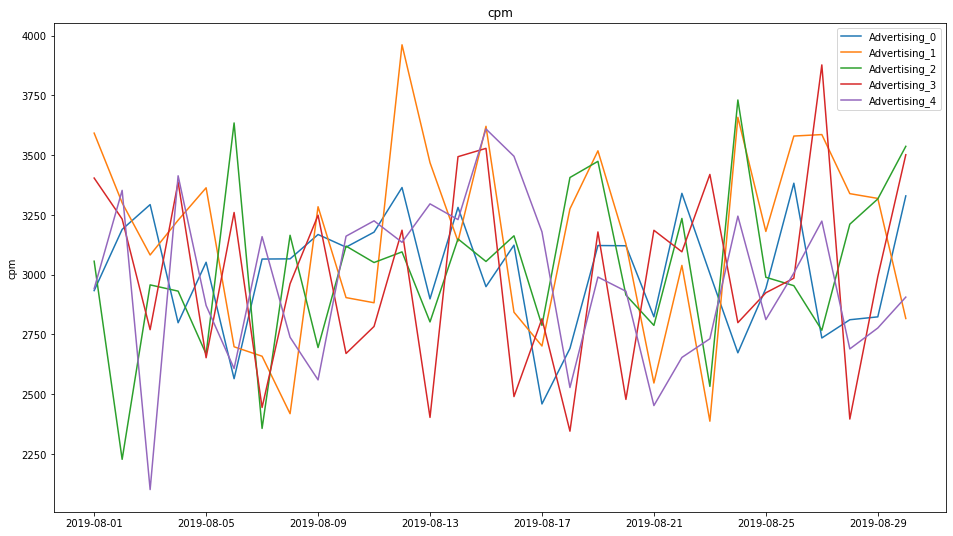

In [325]:
plt.figure(figsize=(16,9))
plt.plot(df_cpm)
plt.legend(df_cpm.columns)
plt.title('cpm')
plt.ylabel('cpm')

Text(0, 0.5, 'ctr')

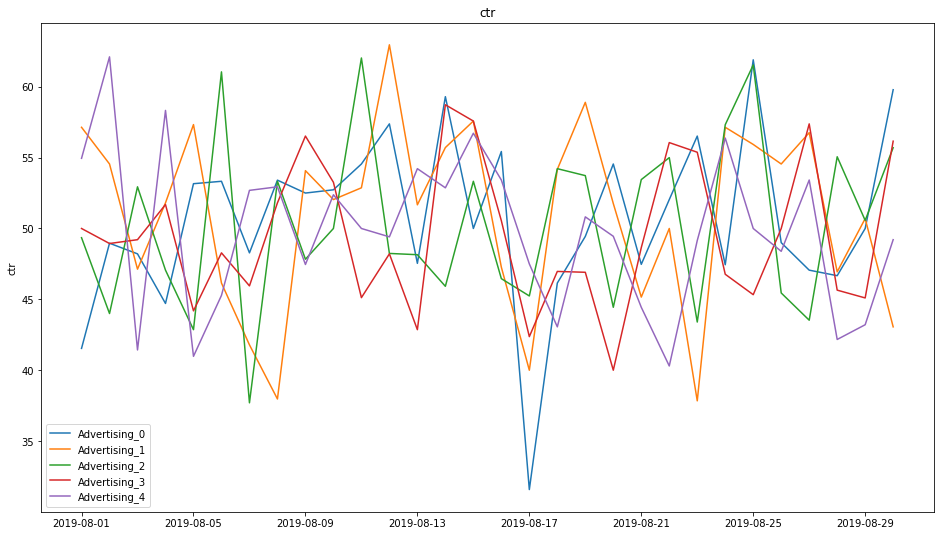

In [326]:
plt.figure(figsize=(16,9))
plt.plot(df_ctr)
plt.legend(df_ctr.columns)
plt.title('ctr')
plt.ylabel('ctr')